In [1]:
import torch
from matplotlib import pyplot as plt
import sys
import time
import os
import numpy as np


#####################################################
# In this notebook, we train a 6-layer linear transformer with
# - context-length 64
# - covariate dimension 16, standard Gaussian distribution (same setup as GPT-2)
# - 
# We plot
# - test loss against number of iterations
# - imshow of each parameter matrix at end of training
# - distance-to-identity of each parameter matrix (this is shown in theory)
#####################################################

#use cuda if available, else use cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#torch.cuda.set_device(1)
# import the model and some useful functions
from linear_transformer import Transformer_F, attention, generate_data, in_context_loss

# set up some print options
np.set_printoptions(precision = 2, suppress = True)
torch.set_printoptions(precision=2)

#begin logging
log_dir = 'log' 
#exp_dir = 'simple_demonstration' 
cur_dir = log_dir #os.path.join(log_dir, exp_dir)
os.makedirs(cur_dir, exist_ok=True)
#f = open(cur_dir + '/train.log', "a", 1)
#sys.stdout = f

In [2]:
# Set up problem parameters

lr = 0.001
clip_r = 1000
alg = 'sgd' # 'adam' or 'sgd'
mode = 'normal'

n_layer = 6 # number of layers of transformer
N = 64     # context length
d = 12        # dimension


n_head = 2 # 2-headed attention
B = 64  # 1000 minibatch size
var = 0.0001  # initializations scale of transformer parameter
shape_k = 0.1  # shape_k: parameter for Gamma distributed covariates
max_iters = 10000  # Number of Iterations to run
hist_stride = 1  # stride for saved model paramters in `train.ipynb'
stride = 100

# a convenience function for taking a step and clipping
def clip_and_step(allparam, optimizer, clip_r = None):
    norm_p=None
    grad_all = allparam.grad
    if clip_r is not None:
        norm_p = grad_all.norm().item()
        if norm_p > clip_r:
            grad_all.mul_(clip_r/norm_p)
    optimizer.step()
    return norm_p

In [3]:
filename_format = '/linearTF_exp_{}_{}_{}_{}.pth'
filename = filename_format.format(n_layer, N, d, alg)
filename = (cur_dir + filename)
hist_dict = {}


seeds = [0] # use one seed 
keys = [(s,) for s in seeds]
for key in keys:
    sd = key[0]
    
    prob_seed = sd
    opt_seed = sd
    
    hist_dict[key] = []
    
    #set seed and initialize model
    torch.manual_seed(opt_seed)
    model = Transformer_F(n_layer, n_head, d, var)
    model.to(device)
    #initialize algorithm. Important: set beta = 0.9 for adam, 0.999 is very slow
    if alg == 'sgd':
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0)
        print("sgd training")
    elif alg == 'adam':
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.9), weight_decay=0)
        print("adam training")
    else: assert False
    
    #set seed and initialize initial training batch
    np.random.seed(prob_seed)
    torch.manual_seed(prob_seed)
    
    for t in range(max_iters):
        start = time.time()
        # save model parameters
        if t%hist_stride ==0:
            hist_dict[key].append(model.allparam.clone().detach())
        #  generate a new batch of training set
        Z, y = generate_data(mode,N,d,B,shape_k)
        Z = Z.to(device)
        y = y.to(device)
        loss = in_context_loss(model, Z, y)
        
        # compute gradient, take step
        loss.backward()
        norms = clip_and_step(model.allparam, optimizer, clip_r=clip_r)
        optimizer.zero_grad()
        end=time.time()
        if t%100 ==0 or t<5:
            print('iter {} | Loss: {}  time: {}  gradnorm: {}'.format(t,loss.item(), end-start, norms))
    #save to 
torch.save({'hist_dict':hist_dict}, filename)

sgd training
iter 0 | Loss: 8.107519149780273  time: 5.456432580947876  gradnorm: 39.835365295410156
iter 1 | Loss: 10.158327102661133  time: 0.40486884117126465  gradnorm: 58.32535934448242
iter 2 | Loss: 9.788507461547852  time: 0.40426087379455566  gradnorm: 38.7132682800293
iter 3 | Loss: 11.527570724487305  time: 0.21636700630187988  gradnorm: 44.708045959472656
iter 4 | Loss: 10.538276672363281  time: 0.016579389572143555  gradnorm: 42.50455856323242
iter 100 | Loss: 0.4030052423477173  time: 0.30339956283569336  gradnorm: 1.4950449466705322
iter 200 | Loss: 0.1931128352880478  time: 0.05970358848571777  gradnorm: 0.710849940776825
iter 300 | Loss: 0.08821690082550049  time: 0.04113578796386719  gradnorm: 0.3783676028251648
iter 400 | Loss: 0.12007317692041397  time: 0.06578516960144043  gradnorm: 0.5139545202255249
iter 500 | Loss: 0.13635064661502838  time: 0.438657283782959  gradnorm: 0.5683927536010742
iter 600 | Loss: 0.084805428981781  time: 0.14070868492126465  gradnorm: 0

In [4]:
####################################
# compute test loss
####################################
hist_dict = torch.load(filename)['hist_dict']
loss_dict = {}
for key in hist_dict:
    sd = key[0]
    
    loss_dict[key] = torch.zeros(max_iters // stride)
    
    np.random.seed(99)
    torch.manual_seed(99)
    Z, y = generate_data(mode, N, d, B, shape_k)
    Z = Z.to(device)
    y = y.to(device)
    model = Transformer_F(n_layer, n_head, d, var).to(device)
    print(sum(p.numel() for p in model.parameters() if p.requires_grad))
    for t in range(0,max_iters,stride):
        with torch.no_grad():
            model.allparam.copy_(hist_dict[key][t])
        loss_dict[key][t // stride] = in_context_loss(model, Z, y).item()

3456


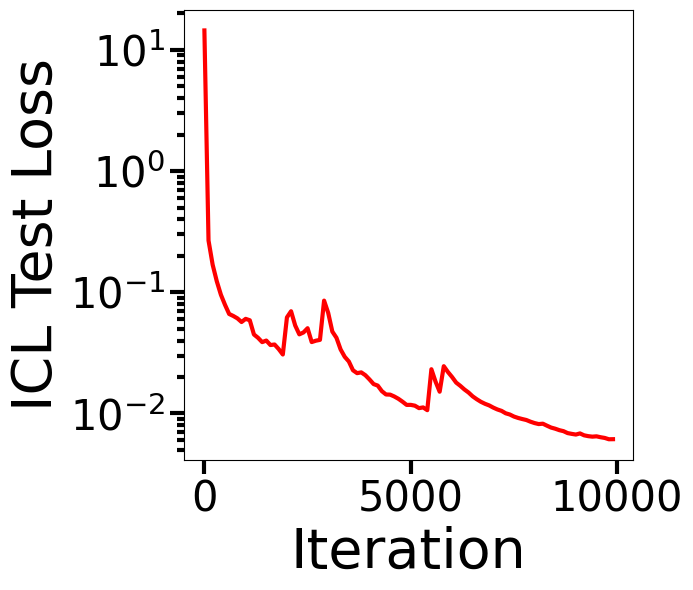

In [5]:
####################################
# plot the test loss with error bars
####################################

fig_dir = 'figures' 
os.makedirs(fig_dir, exist_ok=True)

fig, ax = plt.subplots(1, 1,figsize = (7, 6))

losses = torch.zeros(len(seeds), max_iters//stride)
keys = loss_dict.keys()
for idx, key in enumerate(keys):
    losses[idx,:] = loss_dict[key]
losses_mean = torch.mean(losses, axis=0)
losses_std = torch.std(losses, axis=0)
ax.plot(range(0,max_iters,stride), losses_mean, color = 'red', lw = 3)#, label='Adam')
ax.fill_between(range(0,max_iters,stride), losses_mean-losses_std, losses_mean+losses_std, color = 'red', alpha = 0.2)
ax.set_xlabel('Iteration',fontsize=40)
ax.set_ylabel('ICL Test Loss',fontsize=40)
ax.tick_params(axis='both', which='major', labelsize=30, width = 3, length = 10)
ax.tick_params(axis='both', which='minor', labelsize=20, width = 3, length = 5)
#ax.legend(fontsize=30)
ax.set_yscale('log')


plt.tight_layout()
plt.savefig(fig_dir + '/simple_demonstration_loss_plot + {filename}.pdf', dpi=600)

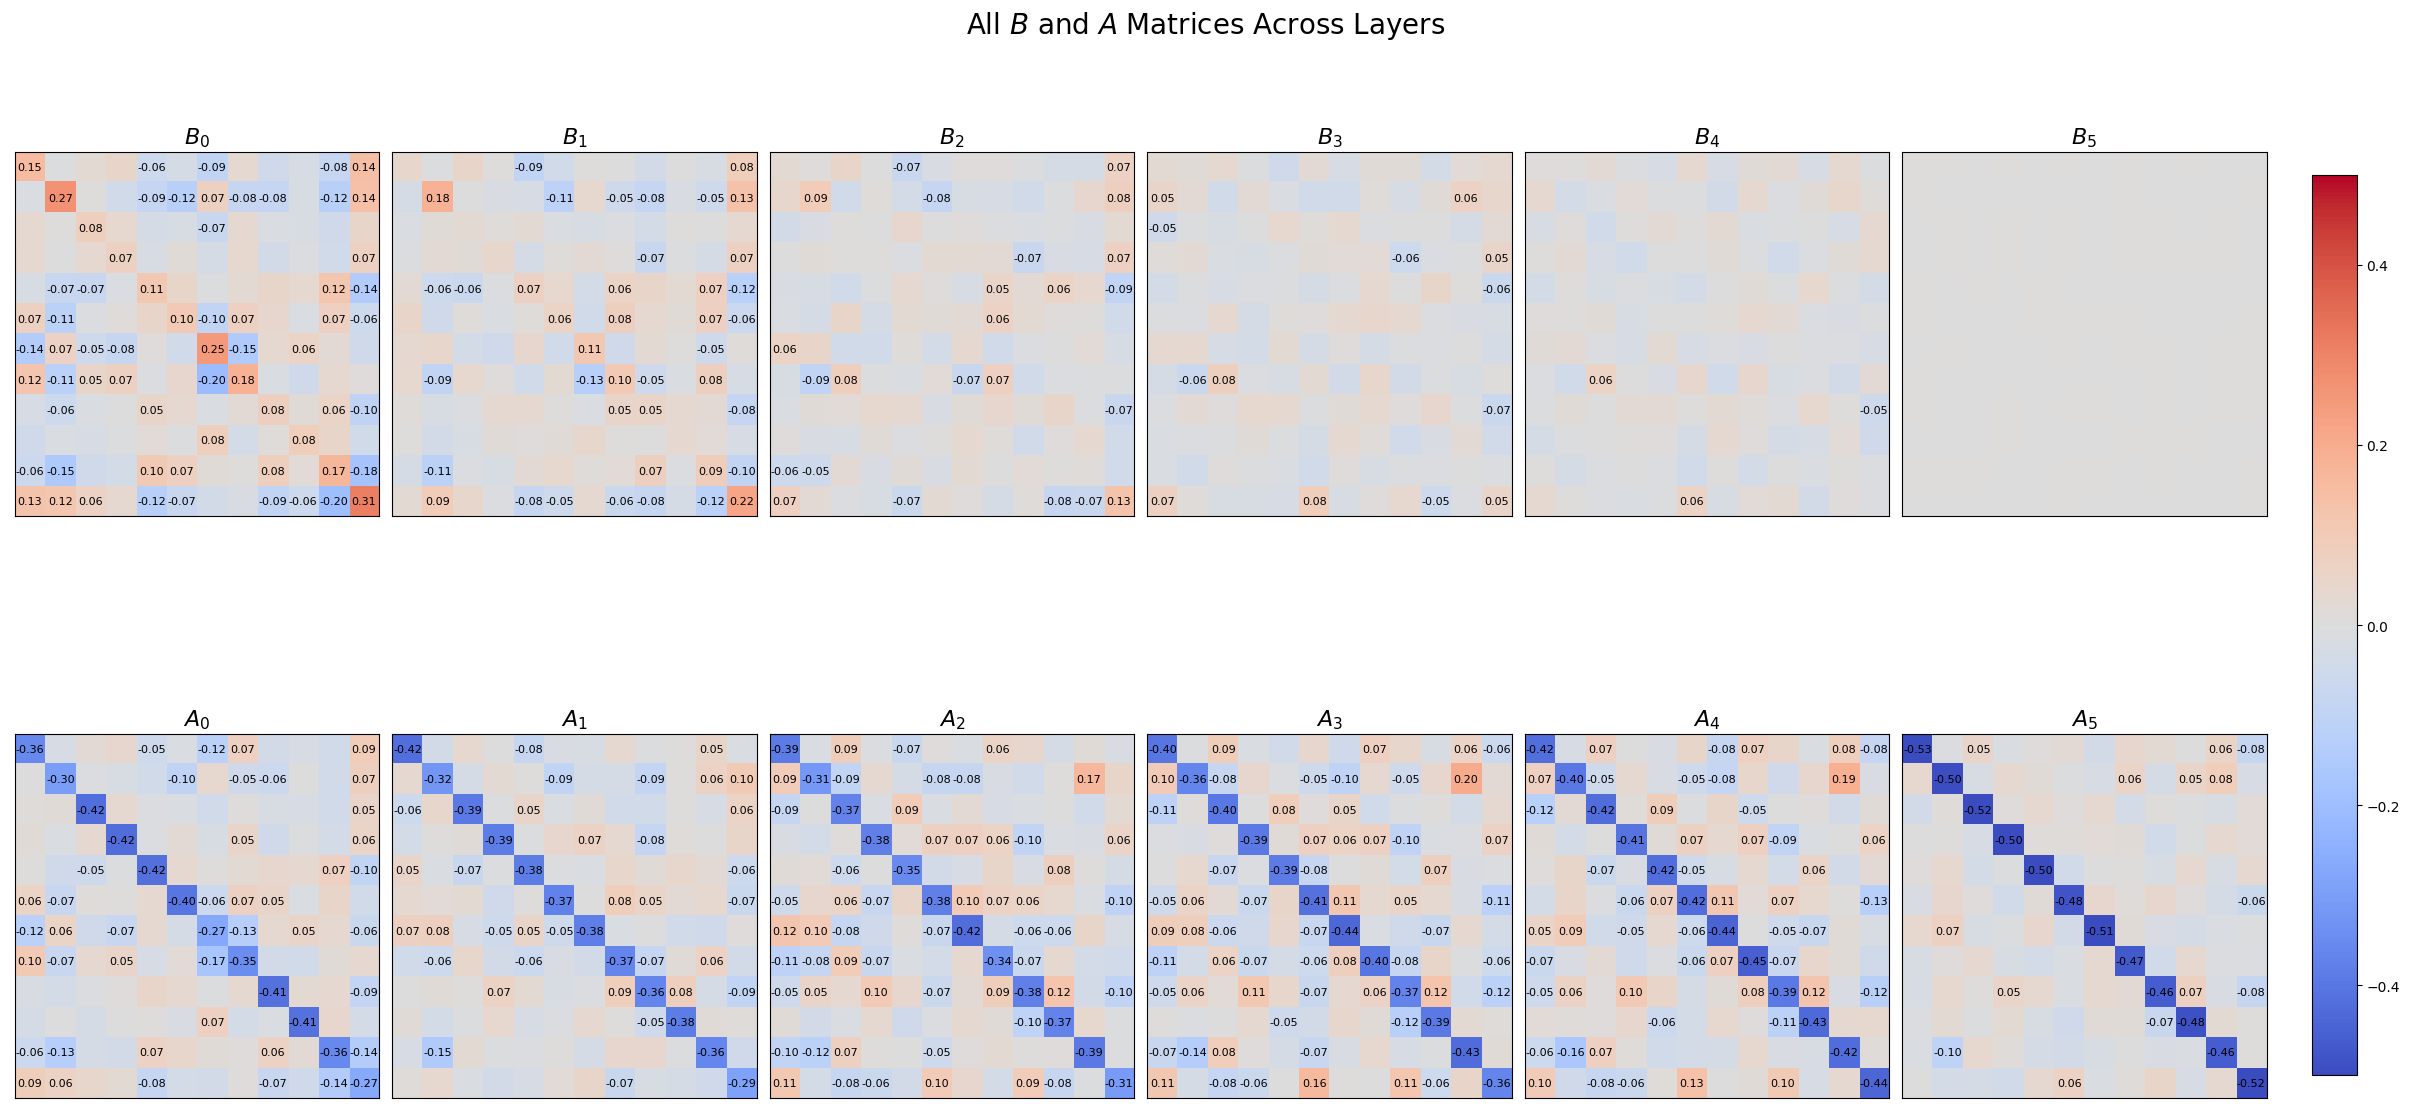

In [9]:
####################################
# Display B and A Matrices in a Combined Grid Layout
####################################

key = (0,)

# Setup a grid with 2 rows: Top for B matrices, Bottom for A matrices
fig, axes = plt.subplots(2, n_layer, figsize=(4 * n_layer, 12), constrained_layout=True)

# Plot B matrices (Top row)
for l in range(n_layer):
    ax = axes[0, l]
    matrix_B = hist_dict[key][max_iters-1][l, 0, 0, :, :]  # Access B matrix
    im = ax.imshow(matrix_B.cpu(), cmap='coolwarm', vmin=-0.5, vmax=0.5)
    
    # Annotate significant values
    for i in range(matrix_B.shape[0]):
        for j in range(matrix_B.shape[1]):
            value = matrix_B[i, j].item()
            if abs(value) > 0.05:
                ax.text(j, i, f"{value:.2f}", ha='center', va='center', color='black', fontsize=8)
    ax.set_title(f"$B_{l}$", fontsize=16)
    ax.set_xticks([])
    ax.set_yticks([])

# Plot A matrices (Bottom row)
for l in range(n_layer):
    ax = axes[1, l]
    matrix_A = hist_dict[key][max_iters-1][l, 0, 1, :, :]  # Access A matrix
    im = ax.imshow(matrix_A.cpu(), cmap='coolwarm', vmin=-0.5, vmax=0.5)
    
    # Annotate significant values
    for i in range(matrix_A.shape[0]):
        for j in range(matrix_A.shape[1]):
            value = matrix_A[i, j].item()
            if abs(value) > 0.05:
                ax.text(j, i, f"{value:.2f}", ha='center', va='center', color='black', fontsize=8)
    ax.set_title(f"$A_{l}$", fontsize=16)
    ax.set_xticks([])
    ax.set_yticks([])

# Add a single colorbar for the entire figure
fig.colorbar(im, ax=axes, location='right', fraction=0.02, pad=0.02)

# Set the overall title and save the figure
fig.suptitle("All $B$ and $A$ Matrices Across Layers", fontsize=20)
plt.savefig(fig_dir + '/all_B_A_layers_combined.pdf', dpi=600)
plt.show()


In [10]:
########################################################
# plot the distance-to-identity of each matrix with time
########################################################

# function for computing distance to identity
def compute_dist_identity(M):
    scale = torch.sum(torch.diagonal(M))/M.shape[0]
    ideal_identity = scale* torch.eye(M.shape[0]).to(device)
    difference = M - ideal_identity
    err = (torch.norm(difference,p='fro')/torch.norm(M,p='fro')).item()
    return err

########################################
# compute distances (assume n_head = 1)
########################################
dist_dict = {}
            
for key in hist_dict:
    (sd,) = key
    dist_dict[key] = torch.zeros(n_layer, 2, max_iters//stride)

    for t in range(0,max_iters,stride):
        with torch.no_grad():
            allparam = hist_dict[key][t]
        for i in range(n_layer):
            for j in range(2):
                dist_dict[key][i,j,t//stride] = compute_dist_identity(allparam[i,0,j,:,:])

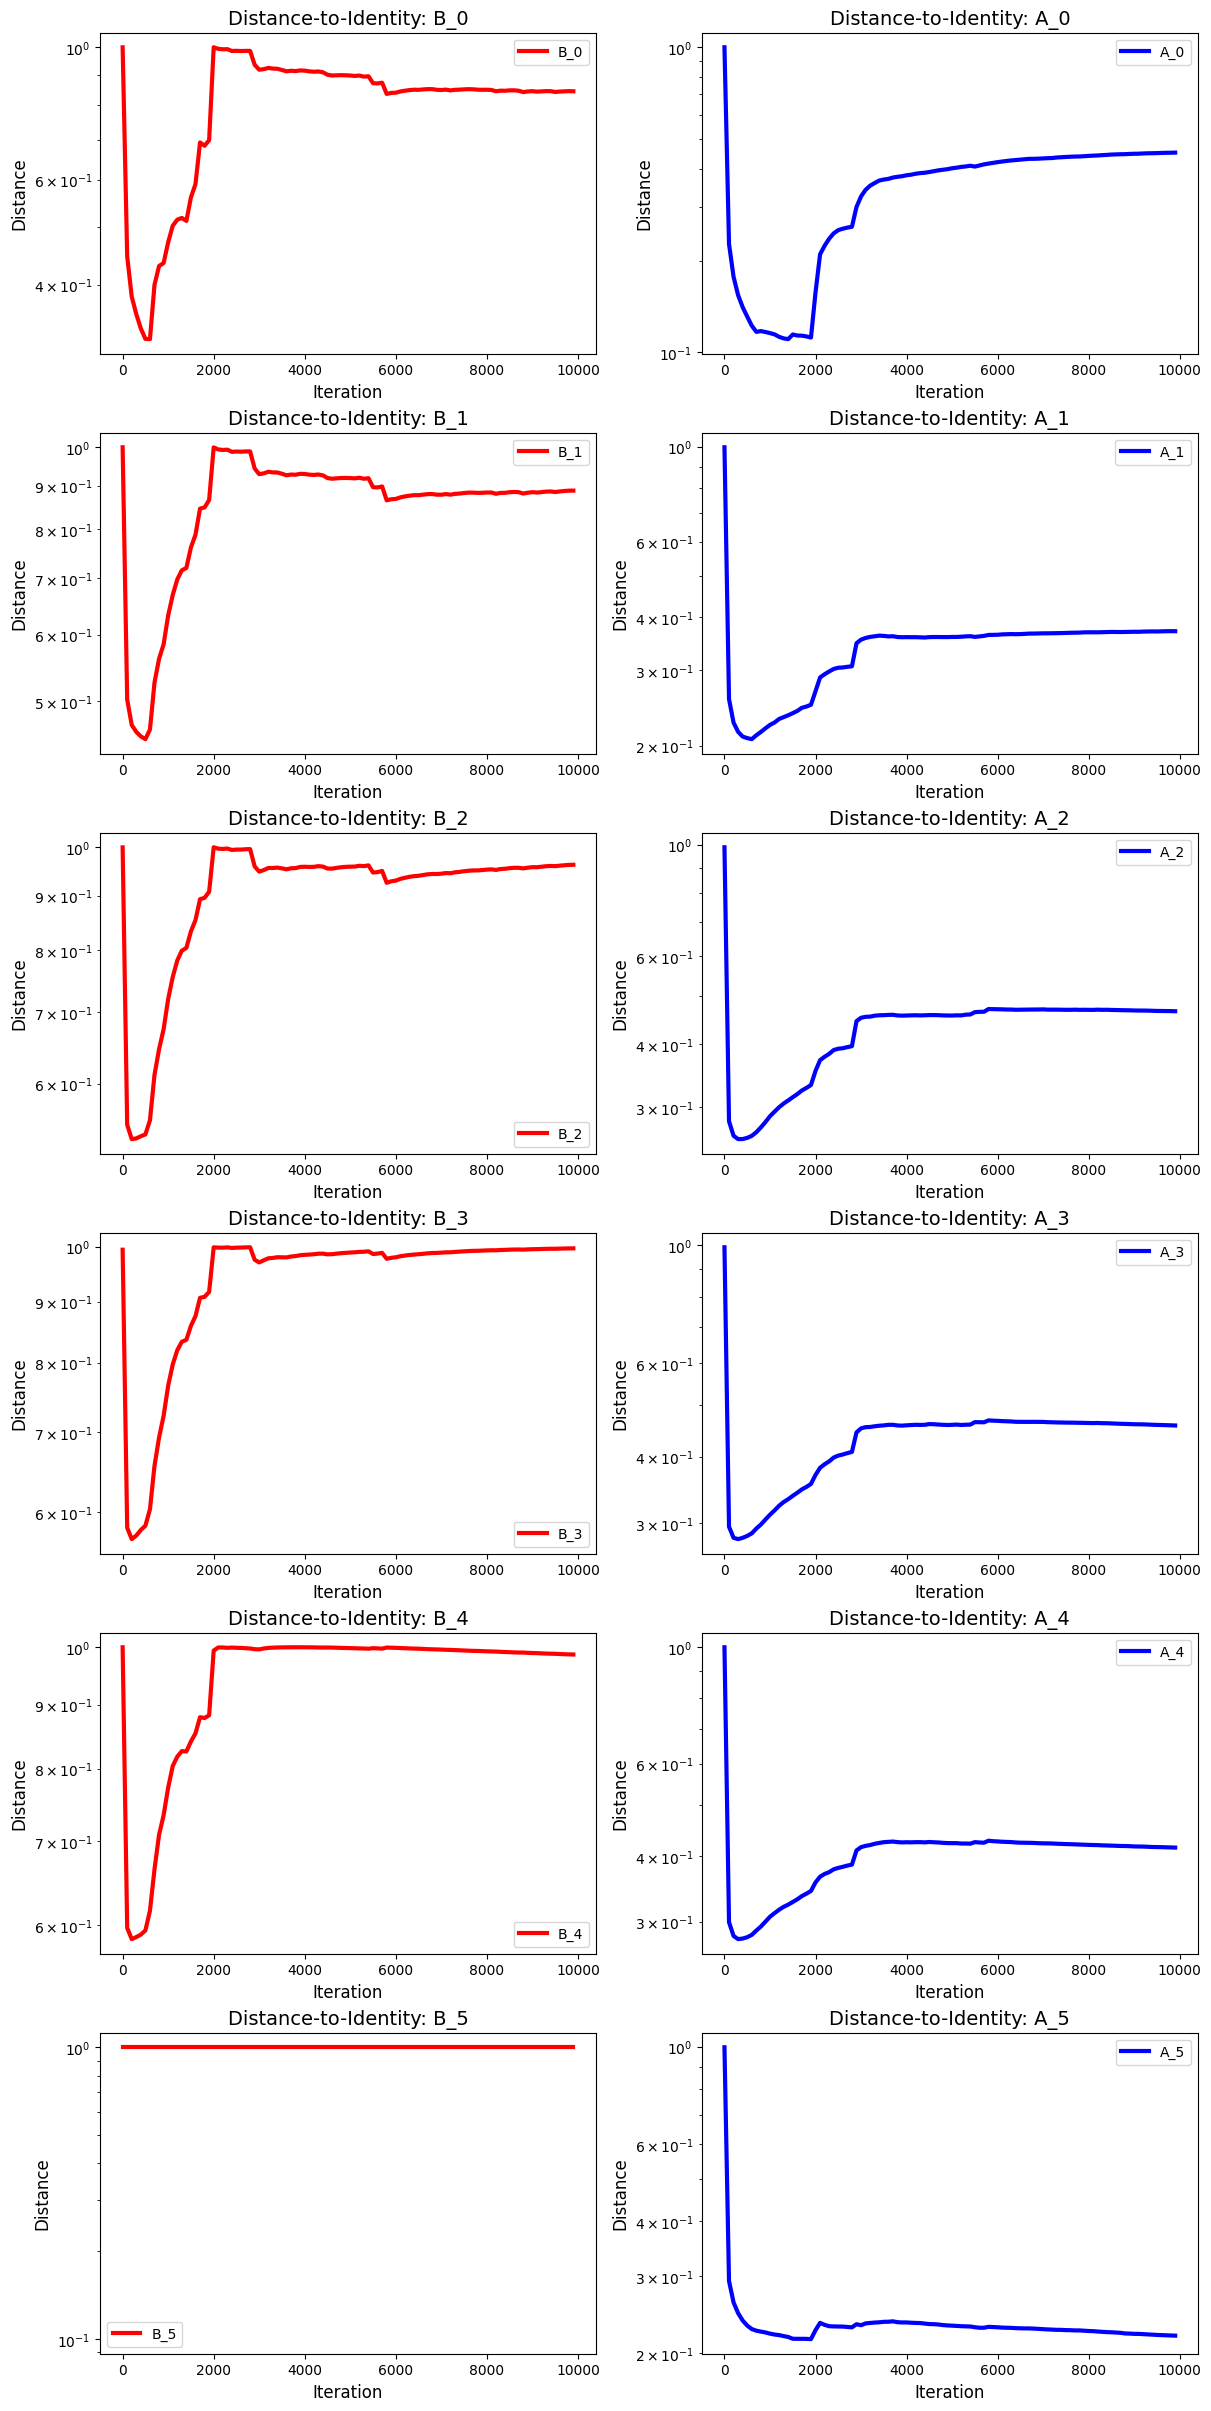

In [11]:
####################################
# Plot distances with corrected subplot indexing
####################################

fig_dir = 'figures'
os.makedirs(fig_dir, exist_ok=True)

# Dynamically set grid size: n_layer rows, 2 columns (B and A matrices)
fig, axs = plt.subplots(n_layer, 2, figsize=(12, 4 * n_layer), constrained_layout=True)

labels = ['B', 'A']  # For the two types of matrices
colors = ['red', 'blue']  # Colors for distinction

for l in range(n_layer):  # Loop through layers
    for pq in range(2):  # 0 for B, 1 for A
        ax = axs[l, pq]  # Access subplot dynamically
        dist_p = torch.zeros(len(seeds), max_iters // stride)
        
        # Gather distances for the current matrix
        for idx, sd in enumerate(seeds):
            dist_p[idx, :] = dist_dict[(sd,)][l, pq, :]
        
        dist_mean = torch.mean(dist_p, axis=0)
        dist_std = torch.std(dist_p, axis=0)

        # Plot distance
        ax.plot(range(0, max_iters, stride), dist_mean, color=colors[pq], lw=3, label=f"{labels[pq]}_{l}")
        ax.fill_between(range(0, max_iters, stride), dist_mean - dist_std, dist_mean + dist_std, 
                        color=colors[pq], alpha=0.2)
        ax.set_yscale('log')
        ax.legend(fontsize=10)
        ax.set_title(f"Distance-to-Identity: {labels[pq]}_{l}", fontsize=14)
        ax.set_xlabel("Iteration", fontsize=12)
        ax.set_ylabel("Distance", fontsize=12)
        ax.tick_params(axis='both', labelsize=10)

# Save the figure
plt.savefig(fig_dir + '/distance_to_identity_fixed.pdf', dpi=600)
plt.show()
